In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import importlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [2]:
from plot import *
from fit import *

In [4]:
figure_folder = "figures_thesis/"

## No Syst

In [3]:
path = "/home/centos/mount_point/data/artificial_experiments/nosyst/train/"
cov_bce = np.load(path + "bce/val_cov.npy").squeeze()
inf_bce = np.load(path + "inferno/val_cov.npy").squeeze()

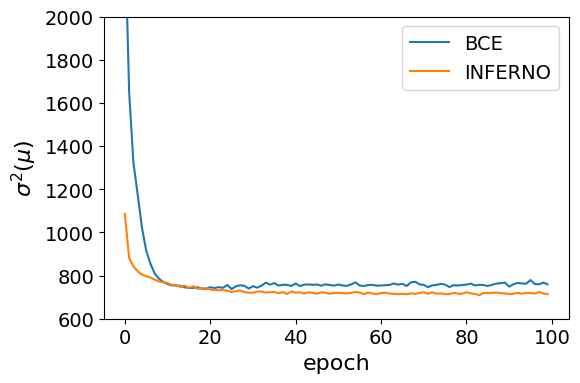

In [5]:
plt.figure(dpi=100)#dpi=150)
plt.plot(cov_bce, label="BCE")
plt.plot(inf_bce, label="INFERNO")
plt.ylabel(r"$\sigma^2(\mu)$", size=16)
plt.xlabel(r"epoch", size=16)
plt.ylim([600, 2000])
plt.legend(loc="upper right", prop={'size': 14})
plt.savefig(figure_folder + "loss_nosyst.pdf", bbox_inches="tight")
plt.show()

In [6]:
bkg = pd.read_hdf("/home/centos/mount_point/data/artificial_experiments/nosyst/samples/QCD.h5")
sig = pd.read_hdf("/home/centos/mount_point/data/artificial_experiments/nosyst/samples/TTJets_signal.h5")

In [7]:
val_bkg = bkg[bkg["is_train"]==False]["inferno"]
val_sig = sig[sig["is_train"]==False]["inferno"]

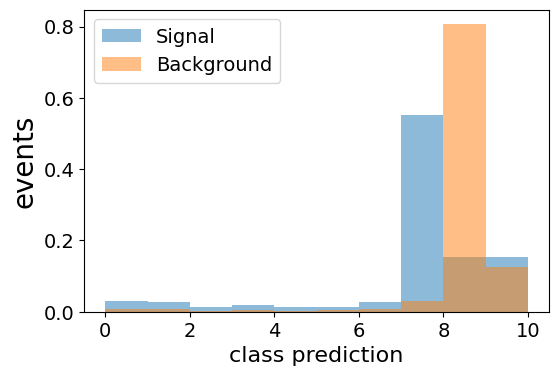

In [22]:
plt.figure(dpi=100)#dpi=150)
plt.hist(val_sig, density=True, alpha=0.5, bins=10, range=[0,10], label="Signal")
plt.hist(val_bkg, density=True, alpha=0.5, bins=10, range=[0,10], label="Background")
plt.xlabel("class prediction", fontsize=16)
plt.ylabel(r"events", fontsize=20)
plt.legend(loc="upper left", prop={'size': 14})
plt.savefig(figure_folder + "inferno_output.pdf", bbox_inches="tight")

In [23]:
path = "/home/centos/mount_point/data/artificial_experiments/nosyst/"
bce_asimov_scan = load_scan( path + "/fit/bce_asimov" )
inferno_asimov_scan = load_scan( path + "/fit/inferno_asimov")
bce_scan = load_scan( path + "/fit/bce" )
inferno_scan = load_scan( path + "/fit/inferno")

In [24]:
def nice_scan(bce, inferno, bce_stat = None, inferno_stat  = None, asimov = True, title = None, name = "llscan", range=[0.7,1.3]):
              
    plt.figure(dpi=100)#dpi=150)
    plt.plot(bce["parameter_values"], bce["delta_nlls"], label="BCE")
    plt.plot(inferno["parameter_values"], inferno["delta_nlls"], label="INFERNO")
    if bce_stat is not None:
        #plt.plot(bce_stat["parameter_values"], bce_stat["delta_nlls"], label="BCE Stat")
        plt.plot(inferno_stat["parameter_values"], inferno_stat["delta_nlls"], label="Stat only")    
    plt.ylim(0,5)
    plt.legend(loc="upper right", prop={'size': 13})
    plt.ylabel(r"$-2 \Delta \log(L)$", size=16)
    plt.xlabel(r'$\mu$', size=16)
    plt.xlim([range[0], range[1]])
    #plt.title("Comparison INFERNO - BCE")
    plt.axhline(y=1, linestyle="dashed", color="grey")
    plt.axhline(y=4, linestyle="dashed", color="grey")
    if title is not None:
        plt.title(title, size=25)
    plt.savefig(figure_folder + name + ".pdf", bbox_inches="tight")

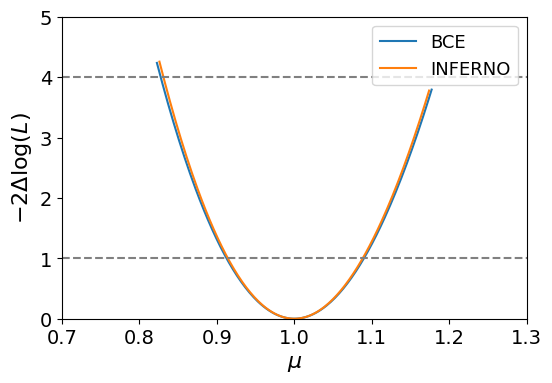

In [25]:
nice_scan(bce_asimov_scan, inferno_asimov_scan, asimov = True, name="ll_nosyst")

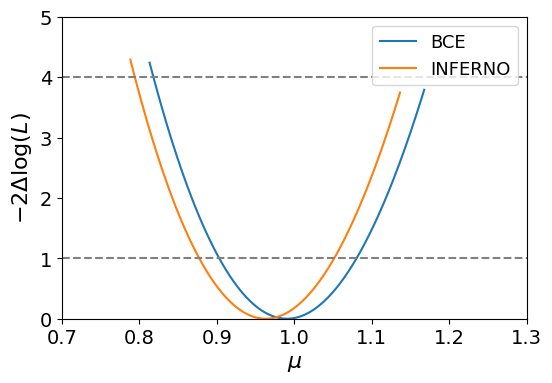

In [26]:
nice_scan(bce_scan, inferno_scan, asimov = True, name = "ll_nosyst_data")

## Differentiable hist

## Artificial syst

In [18]:
path = "/home/centos/mount_point/data/artificial_experiments/artificial_sigshift/shift_2/train/"
cov_bce = np.load(path + "bce/val_cov.npy").squeeze()
inf_bce = np.load(path + "inferno/val_cov.npy").squeeze()

In [20]:
def plot_cov_infbce(bce_covs, inf_covs, names, stddev=False, leg_size = 13, name = "cov"):

    bce_corrs = get_corr(bce_covs)
    inf_corrs = get_corr(inf_covs)    
    n_par = len(names)
    
    fig, ax = plt.subplots(nrows=n_par, ncols=n_par, figsize=(8,8), dpi=100)
    if n_par == 1: ax = [[ax]]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if i == j:
                bce = get_cov_entry(bce_covs, i, j)
                inf = get_cov_entry(inf_covs, i, j)
                if stddev == True:
                    bce = np.sqrt(bce)
                    inf = np.sqrt(inf)
                
                """
                col.text(0.8, 0.85, names[i],
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform = col.transAxes, #size=15,
                 bbox=dict(facecolor='red', edgecolor=None, alpha=0.2))
                """
                
                if i==0:
                    #lims = (500,1500)
                    lims_low = np.min(inf) - 0.1 * np.min(inf)
                    lims_up = np.min(bce) + 0.5 * np.min(bce) 
                    lims = (lims_low, lims_up)
                    if stddev == True:
                        lims = np.sqrt(lims)
                else:
                    lims = (0., 1.5)
            else:
                bce = get_cov_entry(bce_corrs, i, j)
                inf = get_cov_entry(inf_corrs, i, j)
                lims = (-1., 1)
            col.plot(inf, label="INFERNO")
            col.plot(bce, label="BCE")
            col.set_ylim(lims)
            col.set_xlabel("epoch", size=16)
            if i == j:
                col.set_ylabel(r"$\sigma^2(" + names[i] + ")$", size=16)
            else:
                col.set_ylabel(r"$\rho(" + names[i] + "," + names[j] + ")$", size=16)
            if (i==0) & (j==n_par-1):
                col.legend(loc="upper right", prop={'size': leg_size})
                #col.legend(loc="upper right", prop={'size': 16})
    fig.tight_layout()   
    fig.savefig(figure_folder + name + ".pdf", bbox_inches="tight")
    plt.show()            


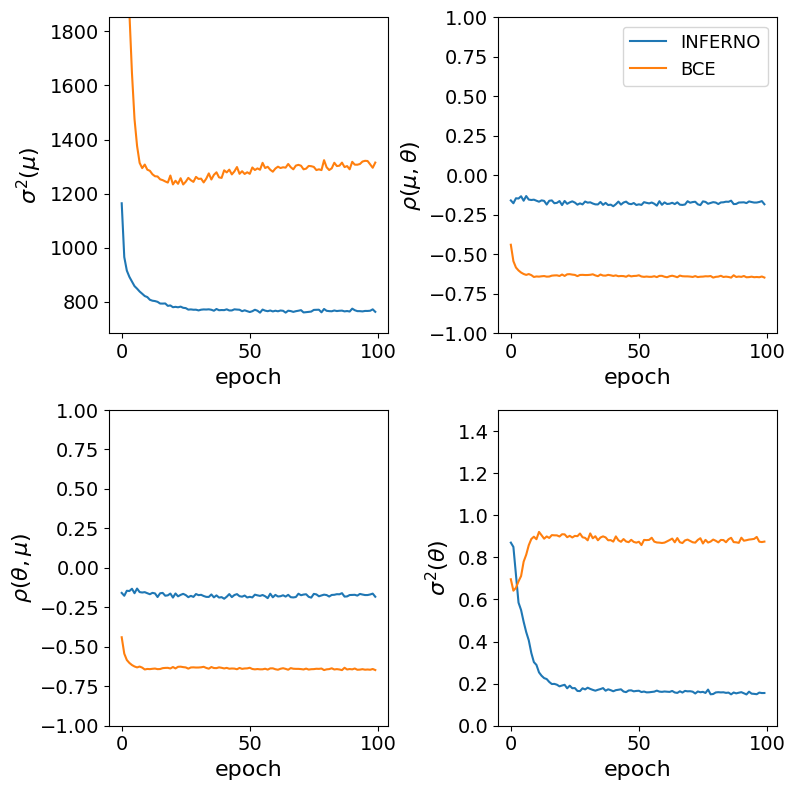

In [21]:
plot_cov_infbce(cov_bce, inf_bce, names = ["\mu", r"\theta"], stddev=False, name="cov_artsig")

In [27]:
path = "/home/centos/mount_point/data/artificial_experiments/artificial_sigshift/shift_2/"
bce_asimov_scan = load_scan( path + "/fit/bce_asimov" )
inferno_asimov_scan = load_scan( path + "/fit/inferno_asimov")
bce_scan = load_scan( path + "/fit/bce" )
inferno_scan = load_scan( path + "/fit/inferno")
bce_asimov_scan_stat = load_scan( path + "/fit/bce_asimov", name='mu_scan_stat' )
inferno_asimov_scan_stat = load_scan( path + "/fit/inferno_asimov", name='mu_scan_stat')

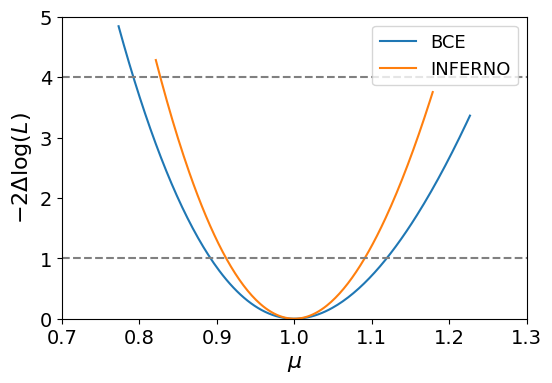

In [28]:
nice_scan(bce_asimov_scan, inferno_asimov_scan, asimov = True, name="llscan_artsig")

## Norm syst

In [29]:
path = "/home/centos/mount_point/data/artificial_experiments/artificial_signorm/norm_2/train/"
cov_bce = np.load(path + "bce/val_cov.npy").squeeze()
inf_bce = np.load(path + "inferno/val_cov.npy").squeeze()

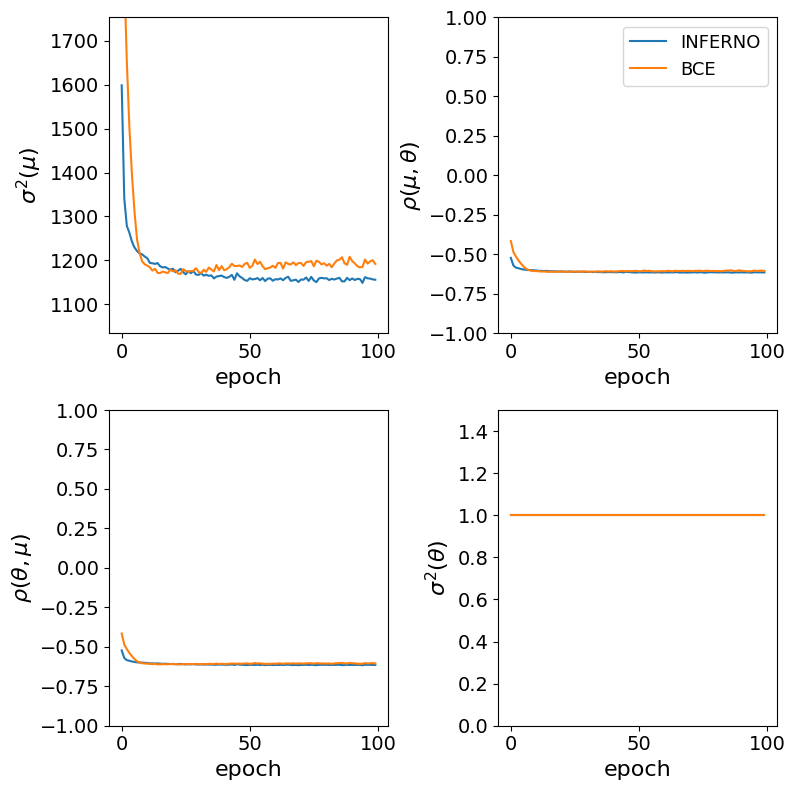

In [30]:
plot_cov_infbce(cov_bce, inf_bce, names = ["\mu", r"\theta"], stddev=False, name="cov_normsig")

## Two nuis

In [31]:
path = "/home/centos/mount_point/data/artificial_experiments/artificial_sigbkg/shift_0/train/"
cov_bce = np.load(path + "bce/val_cov.npy").squeeze()
inf_bce = np.load(path + "inferno/val_cov.npy").squeeze()

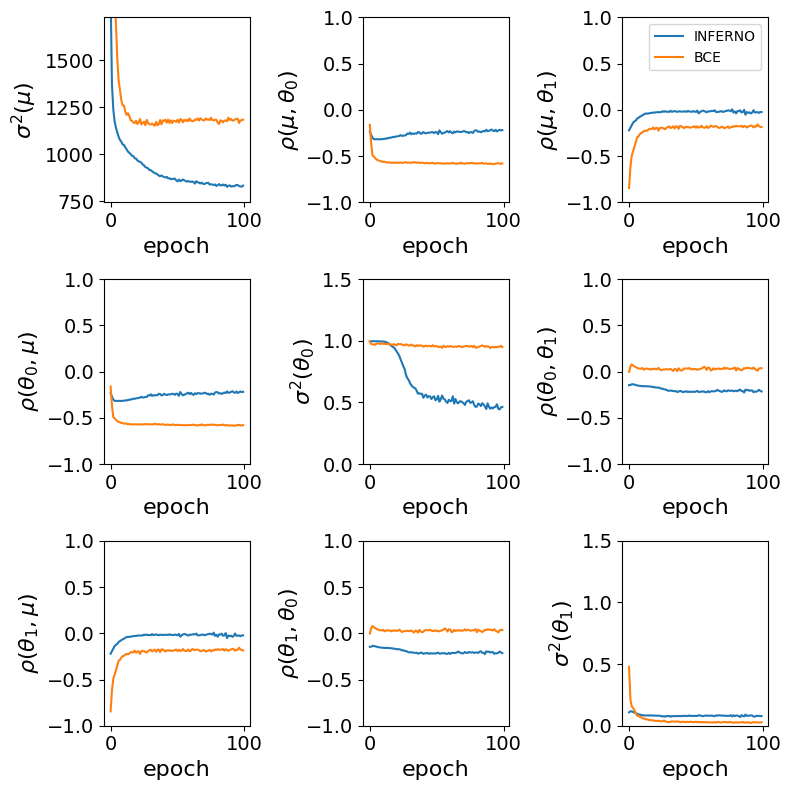

In [32]:
plot_cov_infbce(cov_bce, inf_bce, names = ["\mu", r"\theta_0", r"\theta_1"], stddev=False, leg_size=10, name="cov_bkgsig")

## Single JES syst

In [33]:
path = "/home/centos/mount_point/data/artificial_experiments/shape_syst/jes/train/"
cov_bce = np.load(path + "bce/val_cov.npy").squeeze()
inf_bce = np.load(path + "inferno/val_cov.npy").squeeze()

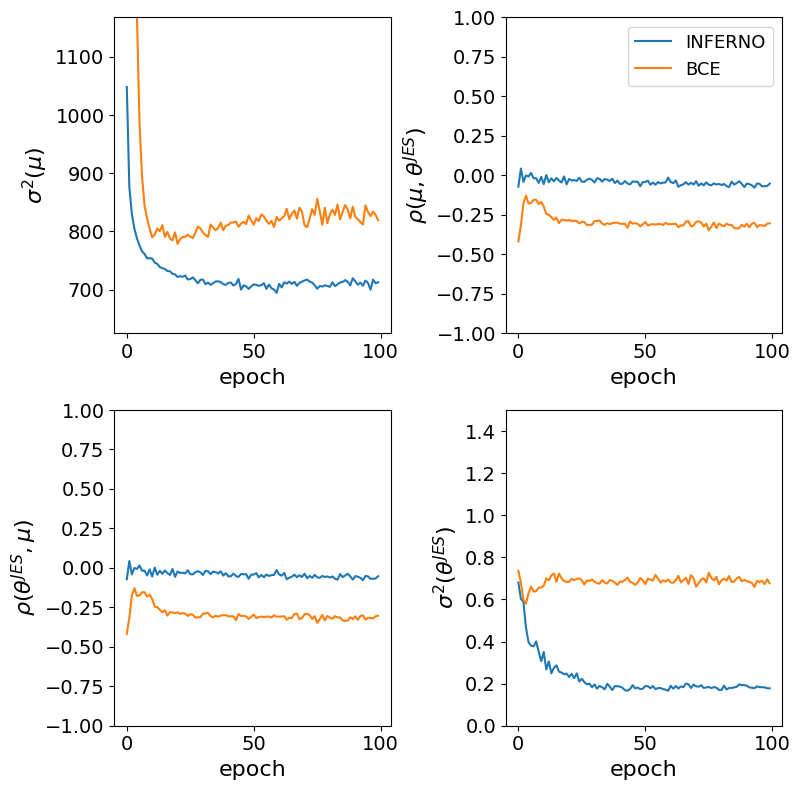

In [34]:
plot_cov_infbce(cov_bce, inf_bce, names = ["\mu", r"\theta^{JES}"], stddev=False, name="cov_jes")

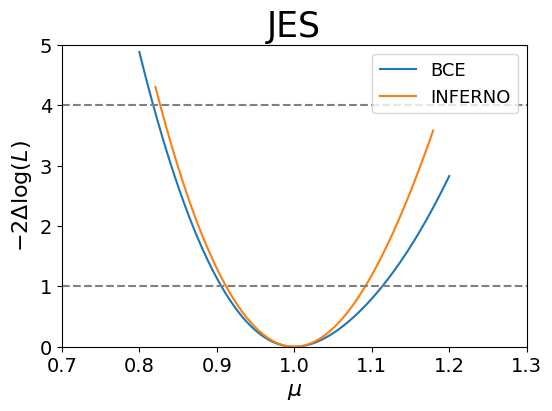

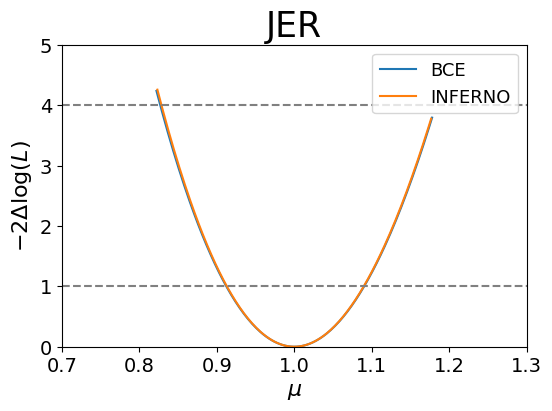

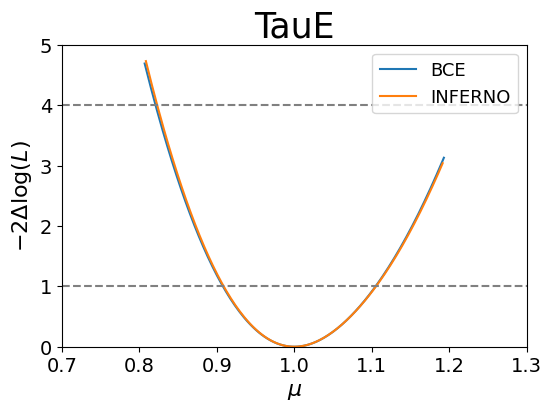

In [35]:
path = "/home/centos/mount_point/data/artificial_experiments/shape_syst/"
for s, t in zip(["jes", "jer", "taue"], ["JES", "JER", "TauE"]):
    bce_asimov_scan = load_scan( path + s + "/fit/bce_asimov" )
    inferno_asimov_scan = load_scan( path + s + "/fit/inferno_asimov")
    nice_scan(bce_asimov_scan, inferno_asimov_scan, asimov = True, title = t, name="llscan_" + s)

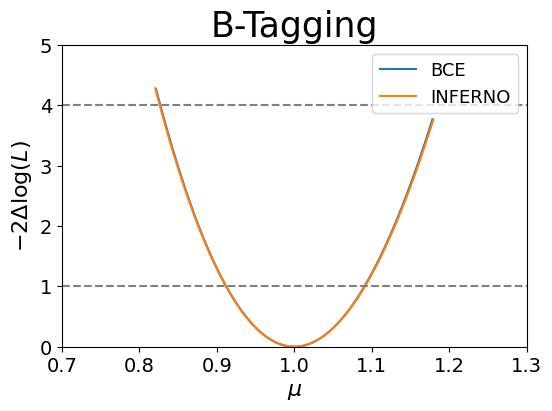

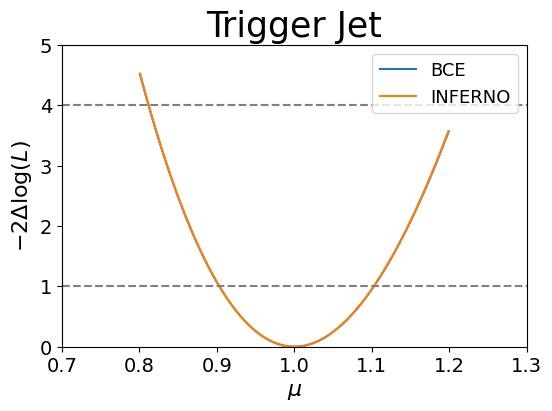

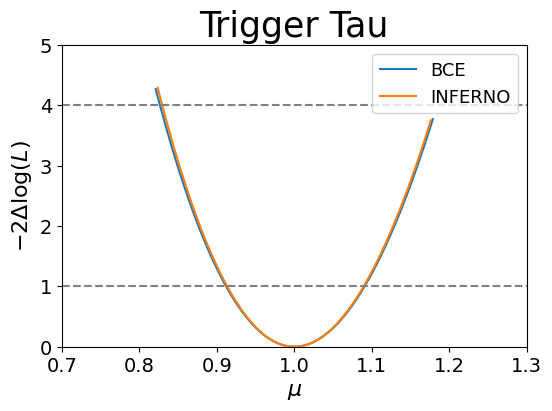

In [34]:
path = "/home/centos/mount_point/data/artificial_experiments/weight_syst/"
for s, t in zip(["btag", "trigger_jet", "trigger_tau"], ["B-Tagging", "Trigger Jet", "Trigger Tau"]):
    bce_asimov_scan = load_scan( path + s + "/fit/bce_asimov" )
    inferno_asimov_scan = load_scan( path + s + "/fit/inferno_asimov")
    nice_scan(bce_asimov_scan, inferno_asimov_scan, asimov = True, title = t, name="llscan_" + s)

## Train with multiple

In [4]:
path = "/home/centos/mount_point/data/artificial_experiments/most_impact/train/"
cov_bce = np.load(path + "bce/val_cov.npy").squeeze()
inf_bce = np.load(path + "inferno/val_cov.npy").squeeze()

In [5]:
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
def plot_cov_infbce(bce_covs, inf_covs, names, stddev=False, leg_size = 13, name = "cov"):

    bce_corrs = get_corr(bce_covs)
    inf_corrs = get_corr(inf_covs)    
    n_par = len(names)
    
    fig, ax = plt.subplots(nrows=n_par, ncols=n_par, figsize=(8,8), dpi=100)
    if n_par == 1: ax = [[ax]]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if i == j:
                bce = get_cov_entry(bce_covs, i, j)
                inf = get_cov_entry(inf_covs, i, j)
                if stddev == True:
                    bce = np.sqrt(bce)
                    inf = np.sqrt(inf)
                
                """
                col.text(0.8, 0.85, names[i],
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform = col.transAxes, #size=15,
                 bbox=dict(facecolor='red', edgecolor=None, alpha=0.2))
                """
                
                if i==0:
                    #lims = (500,1500)
                    lims_low = np.min(inf) - 0.1 * np.min(inf)
                    lims_up = np.min(bce) + 0.5 * np.min(bce) 
                    lims = (lims_low, lims_up)
                    if stddev == True:
                        lims = np.sqrt(lims)
                else:
                    lims = (0., 1.5)
            else:
                bce = get_cov_entry(bce_corrs, i, j)
                inf = get_cov_entry(inf_corrs, i, j)
                lims = (-1., 1)
            col.plot(inf, label="INFERNO")
            col.plot(bce, label="BCE")
            col.set_ylim(lims)
            col.set_xlabel("epoch", size=10)
            if i == j:
                col.set_ylabel(r"$\sigma^2(" + names[i] + ")$", size=10)
            else:
                col.set_ylabel(r"$\rho(" + names[i] + "," + names[j] + ")$", size=10)
            if (i==0) & (j==n_par-1):
                col.legend(loc="upper right", prop={'size': leg_size})
                #col.legend(loc="upper right", prop={'size': 16})
    fig.tight_layout()   
    fig.savefig("figures/" + name + ".pdf", bbox_inches="tight")
    plt.show()            


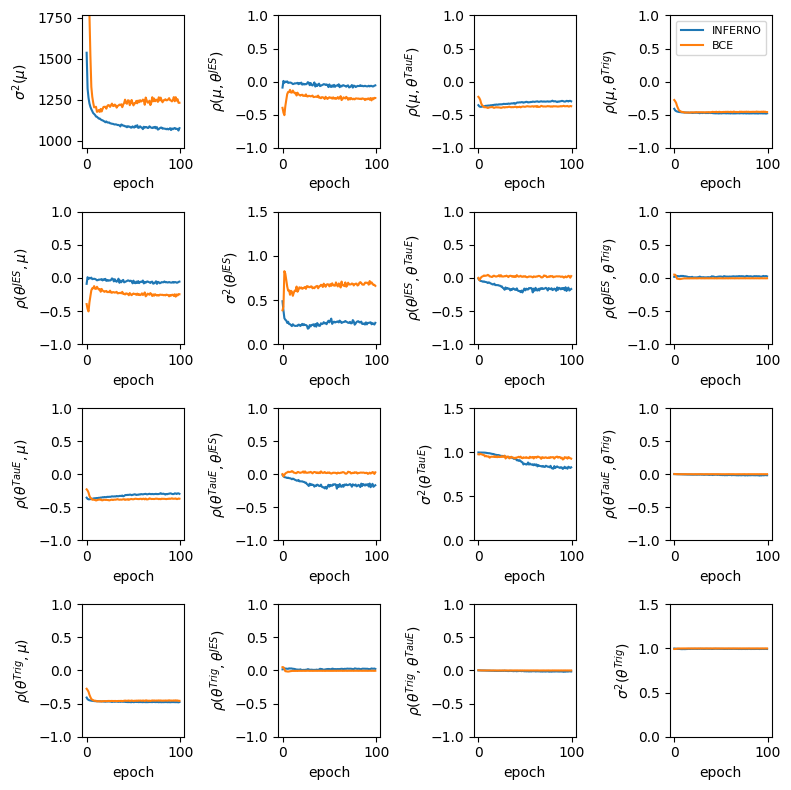

In [6]:
plot_cov_infbce(cov_bce, inf_bce, names = ["\mu", r"\theta^{JES}",  r"\theta^{TauE}",  r"\theta^{Trig}"], leg_size = 8, stddev=False, name="cov_impact")

In [10]:
path = "/home/centos/mount_point/data/artificial_experiments/most_impact/"
bce_asimov_scan = load_scan( path + "/fit/bce_asimov" )
inferno_asimov_scan = load_scan( path + "/fit/inferno_asimov")
bce_scan = load_scan( path + "/fit/bce" )$
inferno_scan = load_scan( path + "/fit/inferno")
bce_asimov_scan_stat = load_scan( path + "/fit/bce_asimov", name='mu_scan_stat' )
inferno_asimov_scan_stat = load_scan( path + "/fit/inferno_asimov", name='mu_scan_stat')

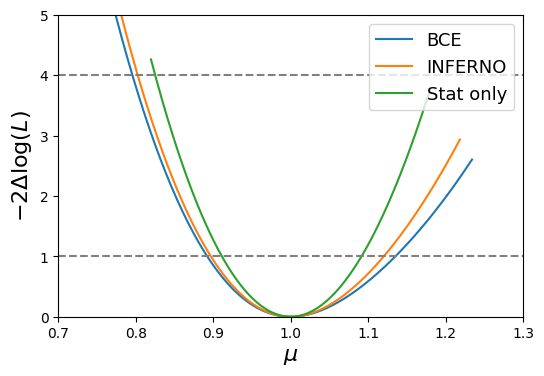

In [11]:
nice_scan(bce_asimov_scan, inferno_asimov_scan, bce_asimov_scan_stat, inferno_asimov_scan_stat, asimov = True, name="llscan_most_impact")


## Train with all

In [12]:
path = "/home/centos/mount_point/data/artificial_experiments/all/"
bce_asimov_scan = load_scan( path + "/fit/bce_asimov" )
inferno_asimov_scan = load_scan( path + "/fit/inferno_asimov")
bce_scan = load_scan( path + "/fit/bce" )
inferno_scan = load_scan( path + "/fit/inferno")
bce_asimov_scan_stat = load_scan( path + "/fit/bce_asimov", name='mu_scan_stat' )
inferno_asimov_scan_stat = load_scan( path + "/fit/inferno_asimov", name='mu_scan_stat')

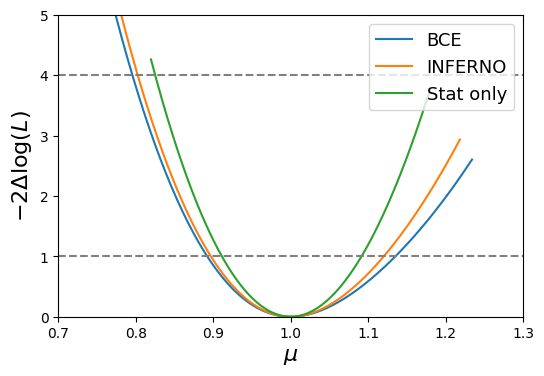

In [14]:
nice_scan(bce_asimov_scan, inferno_asimov_scan, bce_asimov_scan_stat, inferno_asimov_scan_stat, asimov = True, name="llscan_all")

## Final fit

In [40]:
path = "/home/centos/mount_point/data/artificial_experiments/all/fit_single_pdf/fit/"
bce_asimov_scan = load_scan( path + "bce_asimov" )
inferno_asimov_scan = load_scan( path + "inferno_asimov")
bce_scan = load_scan( path + "bce" )
inferno_scan = load_scan( path + "inferno")
bce_asimov_scan_stat = load_scan( path + "bce_asimov", name='mu_scan_stat' )
inferno_asimov_scan_stat = load_scan( path + "inferno_asimov", name='mu_scan_stat')
bce_scan_stat = load_scan( path + "bce", name='mu_scan_stat' )
inferno_scan_stat = load_scan( path + "inferno", name='mu_scan_stat')

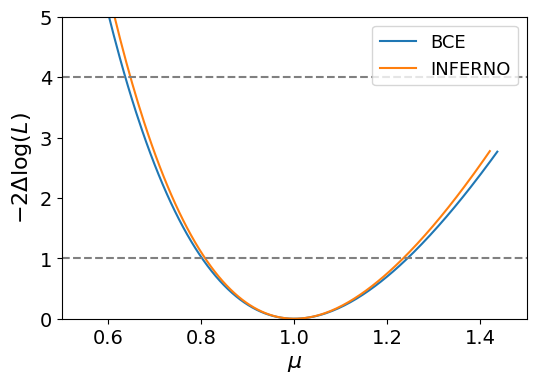

In [33]:
nice_scan(bce_asimov_scan, inferno_asimov_scan, range=(0.5, 1.5), asimov = True, name="llscan_all")

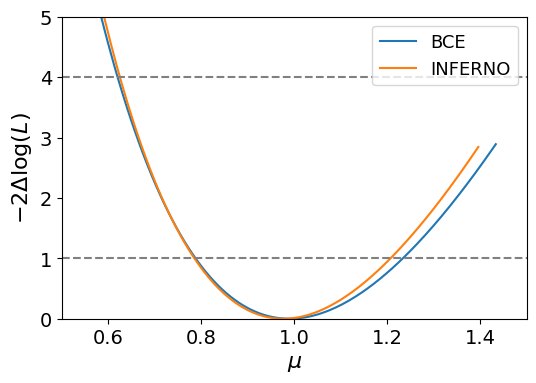

In [31]:
nice_scan(bce_scan, inferno_scan, range=(0.5, 1.5), asimov = True, name="llscan_all")

In [41]:
def nice_scan_bce(bce, bce_stat = None, asimov = True, title = None, name = "llscan", range=[0.7,1.3]):
              
    plt.figure(dpi=100)#dpi=150)
    plt.plot(bce["parameter_values"], bce["delta_nlls"], label="BCE")
    if bce_stat is not None:
        #plt.plot(bce_stat["parameter_values"], bce_stat["delta_nlls"], label="BCE Stat")
        plt.plot(bce_stat["parameter_values"], bce_stat["delta_nlls"], label="Stat only", color="green")    
    plt.ylim(0,5)
    plt.legend(loc="upper right", prop={'size': 13})
    plt.ylabel(r"$-2 \Delta \log(L)$", size=16)
    plt.xlabel(r'$\mu$', size=16)
    plt.xlim([range[0], range[1]])
    #plt.title("Comparison INFERNO - BCE")
    plt.axhline(y=1, linestyle="dashed", color="grey")
    plt.axhline(y=4, linestyle="dashed", color="grey")
    if title is not None:
        plt.title(title, size=25)
    plt.savefig("figures/" + name + ".pdf", bbox_inches="tight")

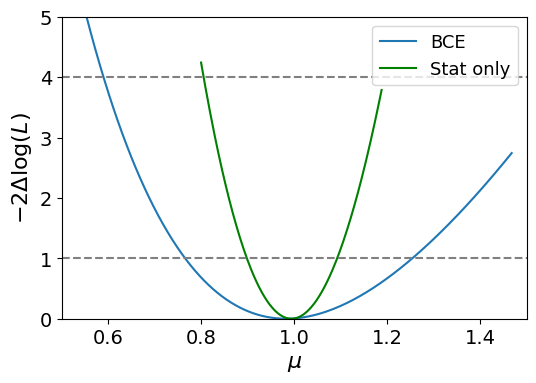

In [42]:
nice_scan_bce(bce_scan, bce_scan_stat, asimov = True, name="llscan_all_real", range=[0.5,1.5])

## Pulls

In [29]:
path = "/home/centos/mount_point/data/artificial_experiments/all/"
bce_asimov = load_fitresults( path + "fit_complete/fit/bce_asimov" )
inferno_asimov = load_fitresults( path + "fit_complete/fit/inferno_asimov")

In [36]:
def pulls(bestfit, uncertainty, labels):
    
    num_pars = len(bestfit)
    y_positions = np.arange(num_pars)[::-1]
    fig, ax = plt.subplots(figsize=(6, 1 + num_pars / 4), dpi=100)
    ax.errorbar(bestfit, y_positions, xerr=uncertainty, fmt="o", color="black")

    ax.fill_between([-2, 2], -0.5, len(bestfit) - 0.5, color="yellow")
    ax.fill_between([-1, 1], -0.5, len(bestfit) - 0.5, color="limegreen")
    ax.vlines(0, -0.5, len(bestfit) - 0.5, linestyles="dotted", color="black")

    ax.set_xlim([-3, 3])
    ax.set_xlabel(r"$\left(\hat{\theta} - \theta_0\right) / \Delta \theta$")
    ax.set_ylim([-0.5, num_pars - 0.5])
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels)
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())  # minor ticks
    ax.tick_params(axis="both", which="major", pad=8)
    ax.tick_params(direction="in", top=True, right=True, which="both")
    fig.set_tight_layout(True)

    #utils._save_and_close(fig, figure_path, close_figure)
    plt.show()

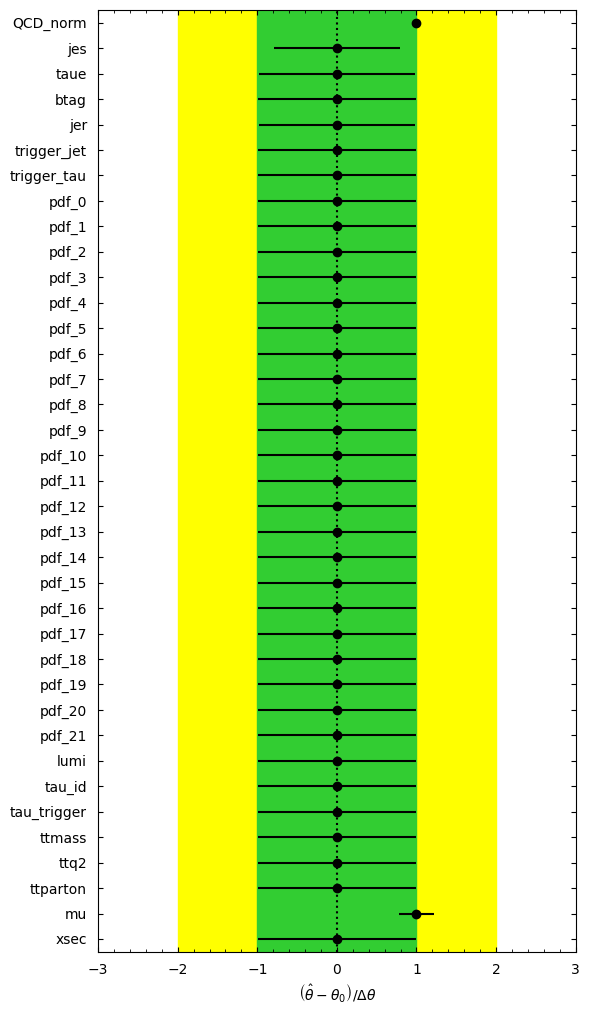

In [37]:
pulls(bce_asimov["bestfit"], bce_asimov["uncertainty"], bce_asimov["labels"])

In [38]:
def correlation_matrix(corr_mat, labels):
    # rounding for test in CI to match reference
    fig, ax = plt.subplots(
        figsize=(round(5 + len(labels) / 1.6, 1), round(3 + len(labels) / 1.6, 1)),
        dpi=100,
    )
    im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap="RdBu")

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")

    fig.colorbar(im, ax=ax)
    ax.set_aspect("auto")  # to get colorbar aligned with matrix
    fig.set_tight_layout(True)

    # add correlation as text
    for (j, i), corr in np.ndenumerate(corr_mat):
        text_color = "white" if abs(corr_mat[j, i]) > 0.75 else "black"
        if abs(corr) > 0.005:
            ax.text(i, j, f"{corr:.2f}", ha="center", va="center", color=text_color)

    plt.show()

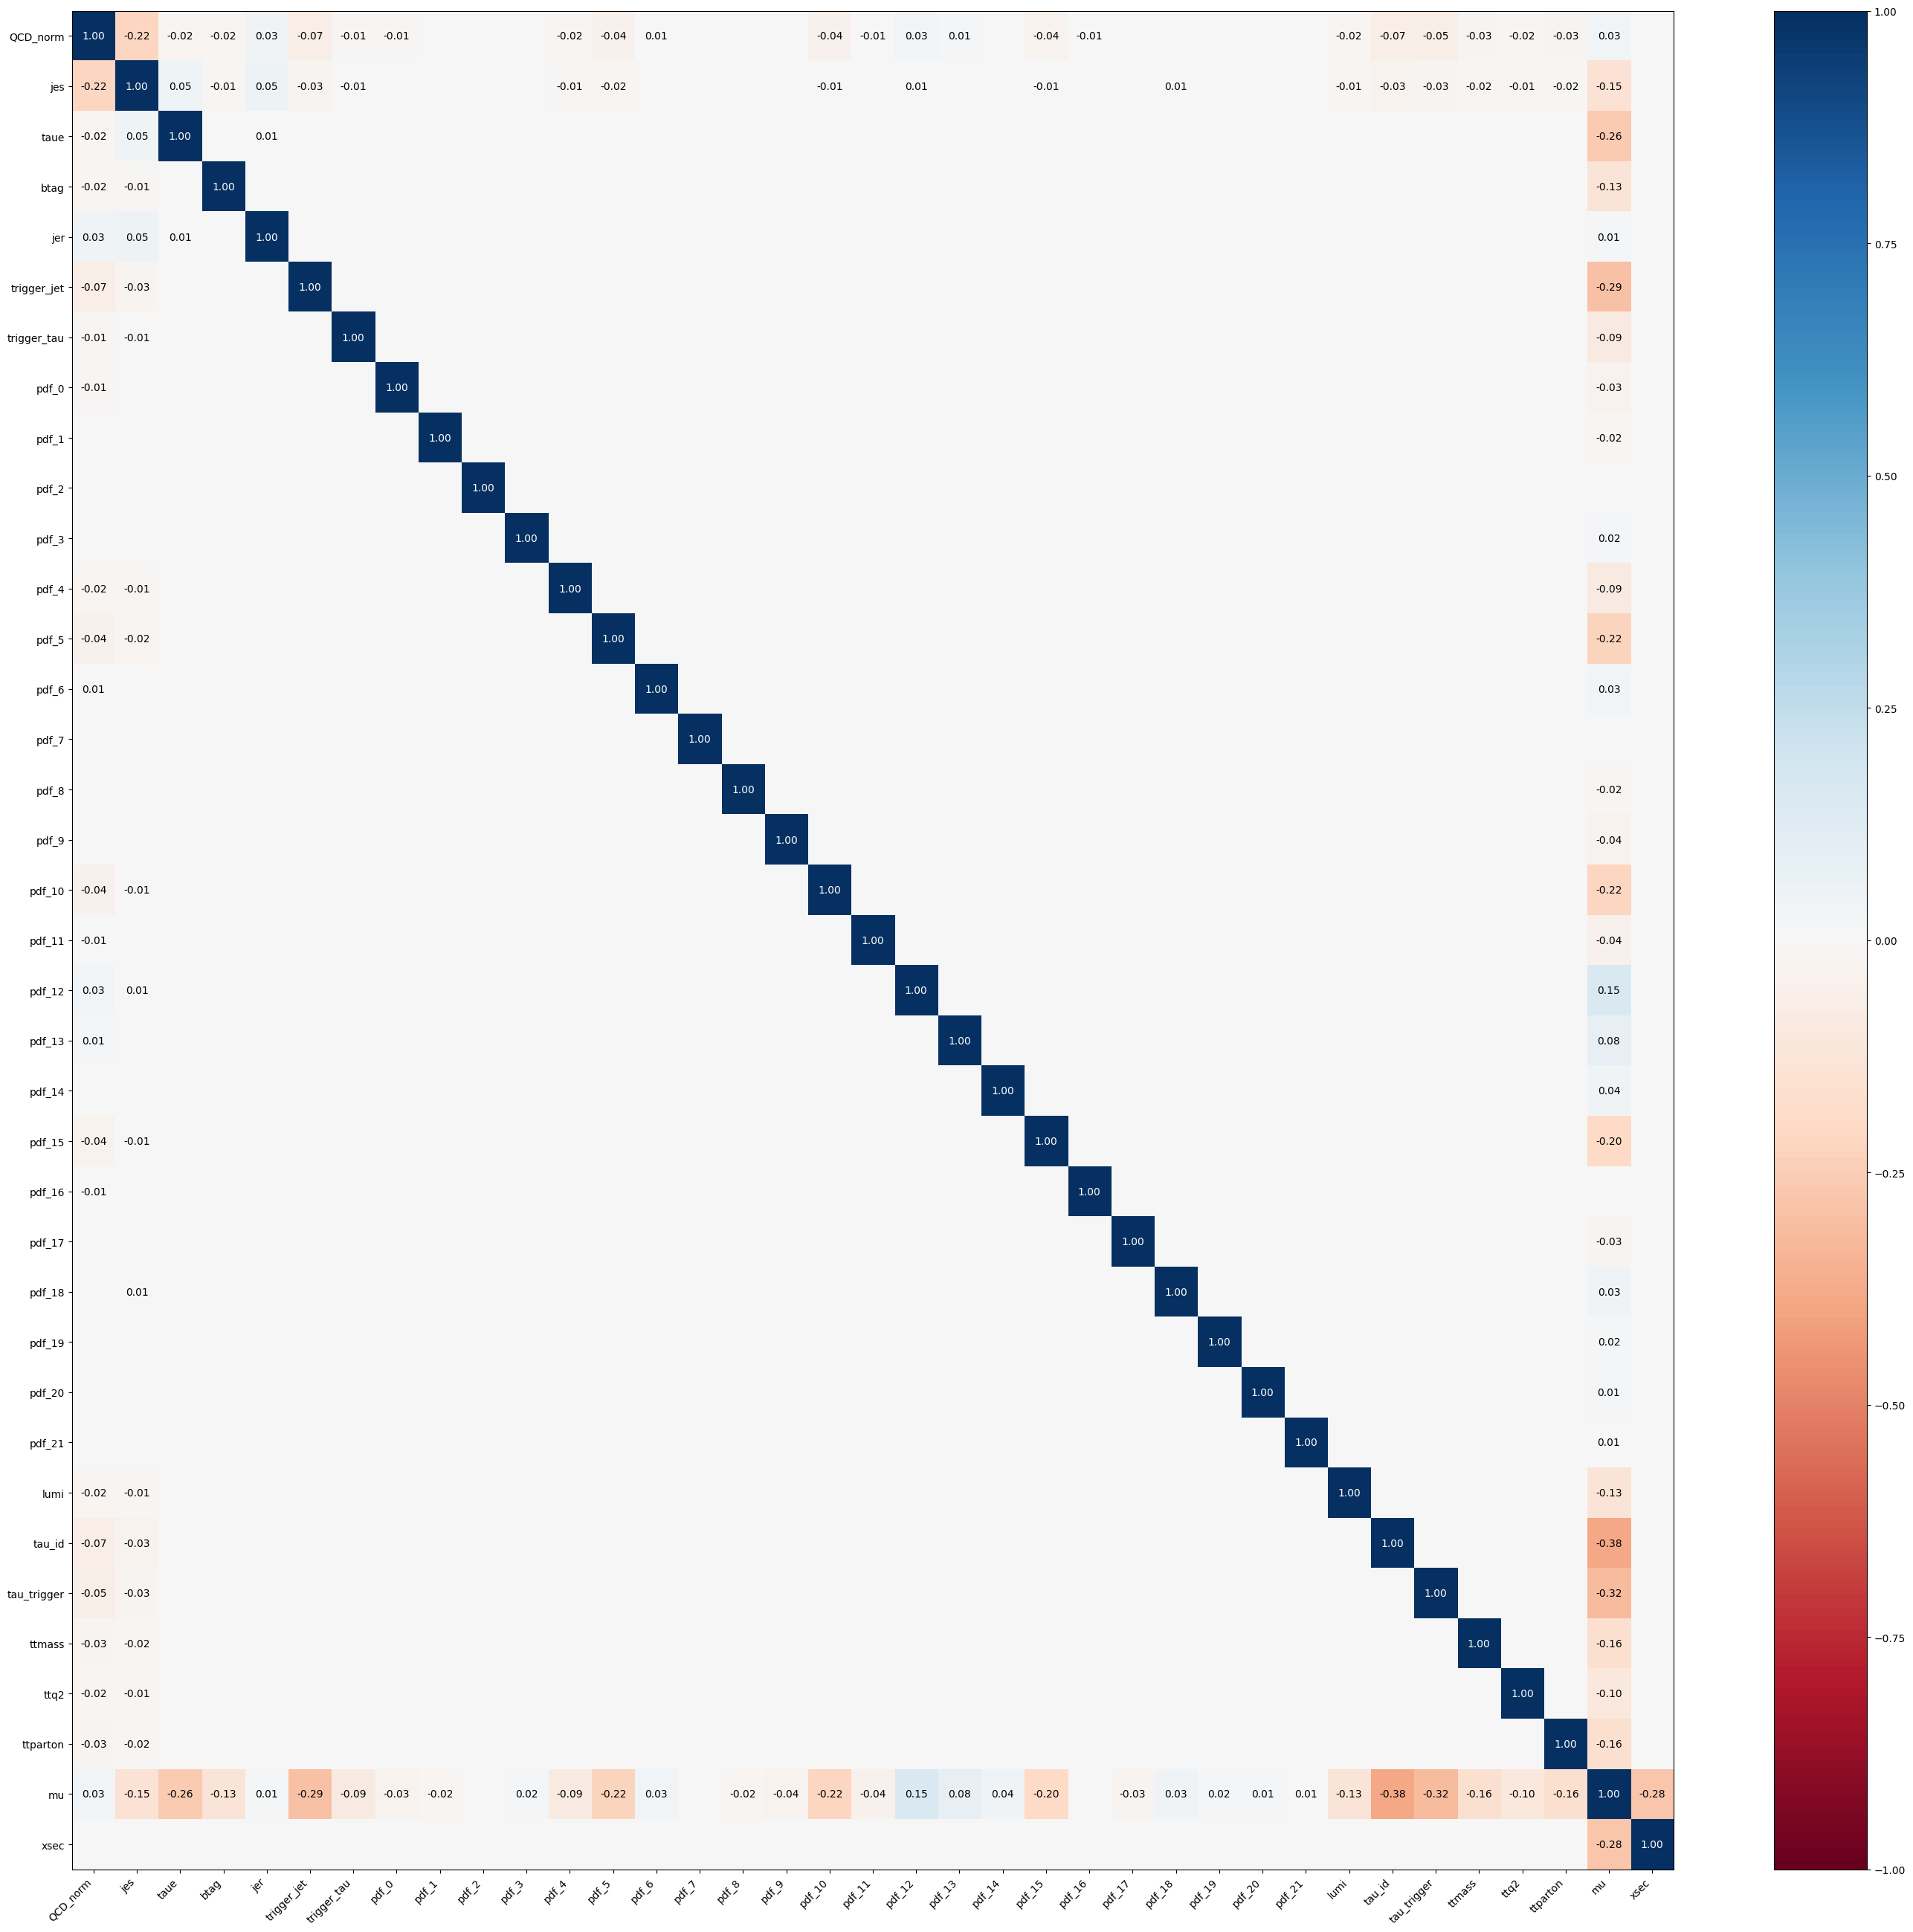

In [42]:
correlation_matrix(bce_asimov["corr_mat"], bce_asimov["labels"])

## Result

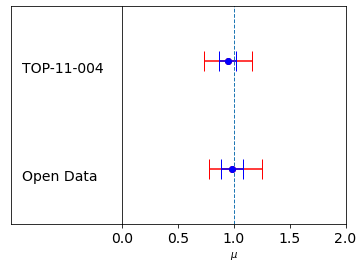

In [27]:
r_orig = 387. / 409.2
r_err = 29. / 387.
r_syst = 0.21 * r_orig
r_tot = np.sqrt((r_err**2 + r_syst**2))


r_bce = 0.983
r_syst_down = 0.21
r_syst_up = 0.27
r_stat_up = 0.095
r_stat_down = 0.098

f, (a1, a0) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
plt.subplots_adjust(wspace=0, hspace=0)
def add_point(x, y, err_x, err_y, color):
    
    asymmetric_error = [[err_x], [err_y]]
    a0.errorbar(x, y, xerr=asymmetric_error, fmt="o", color=color, capsize=10.)
    
add_point(r_orig, 2., r_tot, r_tot, "red")
add_point(r_orig, 2., r_err, r_err, "blue")

add_point(r_bce, 1., r_syst_down, r_syst_up, "red")
add_point(r_bce, 1., r_stat_down, r_stat_up, "blue")

#add_point(df_roofit["TTJets_signal"], 2., df_roofit["TTJets_signal_err"], df_roofit["TTJets_signal_err"], "blue")
#add_point(df_roofit, 2., 0.1, 0.1, "blue")

#add_point(r_syst, 1., err_low_syst, err_high_syst, "red")
#add_point(r_syst, 1., err_low_stat, err_high_stat, "blue")


a0.set_ylim([0.5, 2.5])

a0.set_xlim([0., 2.])
a0.set_yticks([])
a0.set_yticklabels([])
a0.set_xlabel(r"$\mu$")

a1.set_yticks([])
a1.set_yticklabels([])
a1.set_xticks([])
a1.set_xticklabels([])

a0.text(0.1, 0.75, "TOP-11-004", transform=a1.transAxes, fontsize=14, verticalalignment='top')
a0.text(0.1, 0.25, "Open Data", transform=a1.transAxes, fontsize=14, verticalalignment='top')

a1.set_xlim([0., 22.])
#a1.hlines(1.5, 0., 5.)
#a0.hlines(1.5, 0., 5.)
a0.vlines(1., .5, 3.5, linewidth=1., linestyle="dashed")